In [3]:
import os
import glob
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [4]:
# Try to find an Uber CSV in the current directory
candidates = [*glob.glob("uber*.csv"), *glob.glob("*fare*.csv"), *glob.glob("*uber*fare*.csv")]
if not candidates:
    raise FileNotFoundError(
        "CSV not found. Put the dataset in this folder (e.g., 'uber.csv' or 'uber_fare.csv')."
    )

csv_path = candidates[0]
print("Using file ->", csv_path)

df_raw = pd.read_csv(csv_path)
print("Shape:", df_raw.shape)
df_raw.head()

Using file -> uber.csv
Shape: (200000, 9)


,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [5]:
df = df_raw.copy()

# Common column names in this dataset:
# 'fare_amount','pickup_datetime','pickup_longitude','pickup_latitude',
# 'dropoff_longitude','dropoff_latitude','passenger_count'

# Drop obvious NA rows
df = df.dropna(subset=[
    'fare_amount','pickup_datetime','pickup_longitude','pickup_latitude',
    'dropoff_longitude','dropoff_latitude','passenger_count'
])

# Convert types
df['fare_amount'] = pd.to_numeric(df['fare_amount'], errors='coerce')
df['passenger_count'] = pd.to_numeric(df['passenger_count'], downcast='integer', errors='coerce')

# Parse datetime
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], errors='coerce', utc=True)
df = df.dropna(subset=['pickup_datetime'])

print("After basic cleaning:", df.shape)
df.head()


After basic cleaning: (199999, 9)


,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00+00:00,-73.925023,40.744085,-73.973082,40.761247,5


In [6]:
# Haversine distance (km) between (lat1, lon1) and (lat2, lon2)
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0  # km
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2.0)**2
    c = 2*np.arcsin(np.sqrt(a))
    return R * c

df['distance_km'] = haversine(
    df['pickup_latitude'], df['pickup_longitude'],
    df['dropoff_latitude'], df['dropoff_longitude']
)

df['hour'] = df['pickup_datetime'].dt.hour
df['dayofweek'] = df['pickup_datetime'].dt.dayofweek  # 0=Mon ... 6=Sun
df['month'] = df['pickup_datetime'].dt.month
df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)

df[['fare_amount','distance_km','passenger_count','hour','dayofweek','month','is_weekend']].head()


,fare_amount,distance_km,passenger_count,hour,dayofweek,month,is_weekend
0,7.5,1.683323,1,19,3,5,0
1,7.7,2.457590,1,20,4,7,0
2,12.9,5.036377,1,21,0,8,0
3,5.3,1.661683,3,8,4,6,0
4,16.0,4.475450,5,17,3,8,0


In [7]:
# Keep reasonable geographic bounds (NYC-ish but generous)
valid_lat = df['pickup_latitude'].between(40.0, 41.5) & df['dropoff_latitude'].between(40.0, 41.5)
valid_lon = df['pickup_longitude'].between(-75.0, -72.0) & df['dropoff_longitude'].between(-75.0, -72.0)

# Fare and distance sanity
valid_fare = df['fare_amount'].between(2, 200)        # $2 to $200
valid_dist = df['distance_km'].between(0.1, 100)      # 100km cap
valid_pass = df['passenger_count'].between(1, 6)      # 1 to 6 passengers

mask = valid_lat & valid_lon & valid_fare & valid_dist & valid_pass
df = df[mask].copy()

print("After outlier filters:", df.shape)
df[['fare_amount','distance_km','passenger_count']].describe()

After outlier filters: (191893, 14)


,fare_amount,distance_km,passenger_count
count,191893.000000,191893.000000,191893.000000
mean,11.321018,3.382492,1.690619
std,9.482842,3.728733,1.305934
min,2.500000,0.100227,1.000000
25%,6.000000,1.294832,1.000000
50%,8.500000,2.193120,1.000000
75%,12.500000,3.957398,2.000000
max,191.800000,99.162509,6.000000


fare_amount        1.000000
distance_km        0.869361
month              0.024274
passenger_count    0.013320
dayofweek          0.004776
is_weekend        -0.001347
hour              -0.019955
Name: fare_amount, dtype: float64


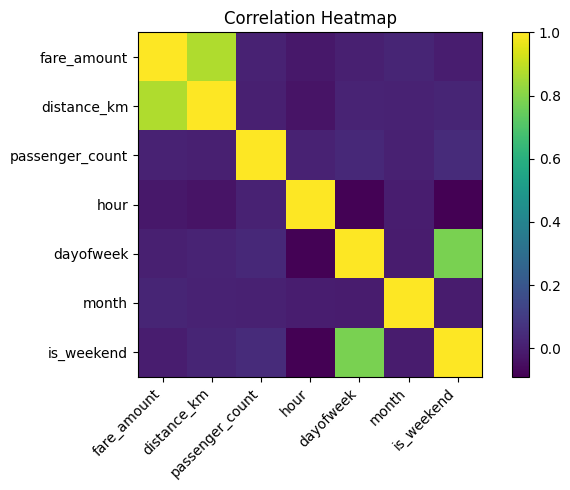

In [8]:
num_cols = ['fare_amount','distance_km','passenger_count','hour','dayofweek','month','is_weekend']
corr = df[num_cols].corr()

print(corr['fare_amount'].sort_values(ascending=False))

# Quick heatmap with matplotlib
plt.figure(figsize=(7,5))
plt.imshow(corr, interpolation='nearest')
plt.xticks(range(len(num_cols)), num_cols, rotation=45, ha='right')
plt.yticks(range(len(num_cols)), num_cols)
plt.colorbar()
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

In [9]:
target = 'fare_amount'
features = ['distance_km','passenger_count','hour','dayofweek','month','is_weekend']

X = df[features].values
y = df[target].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape


((153514, 6), (38379, 6))

In [10]:
linreg = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])

linreg.fit(X_train, y_train)

y_pred_lin = linreg.predict(X_test)

lin_r2   = r2_score(y_test, y_pred_lin)
lin_rmse = mean_squared_error(y_test, y_pred_lin, squared=False)
lin_mae  = mean_absolute_error(y_test, y_pred_lin)

print(f"Linear Regression -> R2: {lin_r2:.4f}, RMSE: {lin_rmse:.4f}, MAE: {lin_mae:.4f}")


TypeError: got an unexpected keyword argument 'squared'